In [1]:
using StaticArrays, DelimitedFiles, StatsBase, Random, Distributions, LinearAlgebra, Formatting, Plots

# indexing tools (new I, d creation function)
include("indexing_tools.jl");

# stencil function
@. f_gauss(r, ξ) = exp(-(r/ξ)^2)
@. f_pow(r, p) = r^(-p)
@. f_rkky(r, ξ) = (2*r/ξ)^(-4) * ((2*r/ξ) * cos(2*r/ξ) - sin(2*r/ξ))

function calc_stencil(var, func, nx, ny)
    # calculate stencil
    tf = 0
    for ii = 0:nx-1
        for jj = 0:ny-1
            # no self coupling
            if ii == 0 && jj == 0
                continue
            else
                # periodic bc
                mod_i = ((ii + nx / 2) % nx) - nx / 2
                mod_j = ((jj + ny / 2) % ny) - ny / 2
                # position on unit lattice
                tr = sqrt(mod_i^2 + mod_j^2)
                # add to stencil weight
                tf += func(tr, var)
            end
        end
    end
    return tf
end

# $\omega$ matching functions

In [ ]:
function calc_equiv_ω(ω_50, Γ)
    
    # functions
    @. A(x,p) = p[1] * x + p[2]
    @. B(x,p) = p[1] + p[2] * x^p[3]

    # slope as a function of Γ coefs (linear)
    m_coefs = [1.92344947071268e-5,
               0.03686314443500012]

    # intercept as a function of Γ coefs (power)
    b_coefs = [0.004044449810225399,
              -3.7174085208351798e-9,
               1.286900442938892]
    
    # calc slope and intercept
    m = A(Γ, m_coefs)
    b = B(Γ, b_coefs)
    
    # calc new ω
    return m*ω_50 + b
    
end

# create $\alpha$ and $\xi$ from $\omega$

In [60]:
# gyromagnetic ratio
γ = 2 * π * 1e6

# linewidth
Γ = 0.05 (MHz)
t_Γ = Γ * 1e6 (Hz)

# create values of ω (planar)
num_ωp = 15
ω0 = 2.5 * (2 * π * t_Γ / γ)
ωf = 4.5 * (2 * π * t_Γ / γ)
ωp_list = exp10.(LinRange(log10(ω0), log10(ωf), num_ωp))

# create values of ω (out of plane)
num_ωz = 15
ω0 = 2.5 * (2 * π * t_Γ / γ)
ωf = 4.5 * (2 * π * t_Γ / γ)
ωz_list = exp10.(LinRange(log10(ω0), log10(ωf), num_ωz))

# create values of ξ
num_ξ = 15
tξ_list = exp10.(LinRange(log10(5), log10(25), num_ξ))

# storage for α and ξ
αp_list = Array{Any}(undef, num_ωp*num_ωz*num_ξ)
αz_list = Array{Any}(undef, num_ωp*num_ωz*num_ξ)
ξ_list = Array{Any}(undef, num_ωp*num_ωz*num_ξ)

# get the value of ξ
for ωp_idx = 1:num_ωp
    for ωz_idx = 1:num_ωz
        for ξ_idx = 1:num_ξ

            # flattened index
            idx = num_ωz * num_ξ * (ωp_idx - 1) + num_ξ * (ωz_idx - 1) + ξ_idx

            # current value of w
            tωp = ωp_list[ωp_idx]
            tωz = ωz_list[ωz_idx]
            tξ = tξ_list[ξ_idx]

            # calculate stencil
            tf = calc_stencil(tξ, f_gauss, 400, 400)

            # find the right value of ξ
            αp = tωp / tf
            αz = tωz / tf

            # save result
            αp_list[idx] = αp
            αz_list[idx] = αz
            ξ_list[idx] = ξ
            
        end
    end
end

# save parameters to a file

In [79]:
# create a directory to save them to
dir_name = "p_z_xi_sweep"
if !isdir(dir_name)
    mkdir(dir_name)
end
dir_name *= "/"

# dict to enable printing
t_params = Dict()

# split run in half to reduce computation time
L = convert(Int64, round(length(ξ_list)/2))
r0 = [1, L + 1]
rf = [L, length(ξ_list)]

for p_idx = 1:2 # phase cycling if varying the pulse
    
    # phases to kill fid (can choose a different set)
    phase_list = [[0,1],[0,3]]
    
    for i = 1:length(r0)

        # interaction strenghts
        t_params["αx"] = αp_list[r0[i]:rf[i]] ./ 2
        t_params["αy"] = αp_list[r0[i]:rf[i]] ./ 2
        t_params["αz"] = αz_list[r0[i]:rf[i]]

        # stencil parameters
        t_params["ξ"] = ξ_list[r0[i]:rf[i]]
        t_params["p"] = [2.0] # the decay power.  for gaussian, it is fixed at two right now
        t_params["sten"] = [0] # 0 = gauss, 1 = power, 2 = rkky, anything else = uniform
        t_params["sw"] = [1.0]
        t_params["pw"] = [0.0]
        t_params["dw"] = [0.0]

        # dissipation
        t_params["Γ1"] = [0.0]
        t_params["Γ2"] = [0.0]
        t_params["Γ3"] = [0.0]

        # lattice sizes
        t_params["nx"] = [400]
        t_params["ny"] = [400]

        # time steps
        t_params["τ"] = [50e-6]
        t_params["dt"] = [6*π/10] # use a multiple of π/10 for magnus terms

        # linewidth in MHz (divide linewidth by 2 for CUDA (HWHM), put in full linewidth for Julia (FWHM))
        t_params["line_width"] = Γ / 2

        # flip angles
        t_params["θ90"] = [π/2]
        t_params["θ180"] = 2 .* t_params["θ90"]
        t_params["θ"] = t_params["θ90"]

        # pulse phases: 0 = x, 1 = y, 2 = -x, 3 = -y
        t_params["phase90"] = phase_list[1][p_idx]
        t_params["phase180"] = phase_list[2][p_idx]

        # define which variables to loop over, and how they are paired
        echo_vars = [("αx", "αy", "αz", "ξ")]
        sim_vars = []

        # make the parameter file and get the dimensions
        make_parameter_file_cuda(t_params, echo_vars, sim_vars, 2*(p_idx-1) + i, true, dir_name);
        # _ = make_parameter_file_julia(params, echo_vars, 1, false);

    end
end

# for checking frequency distributions

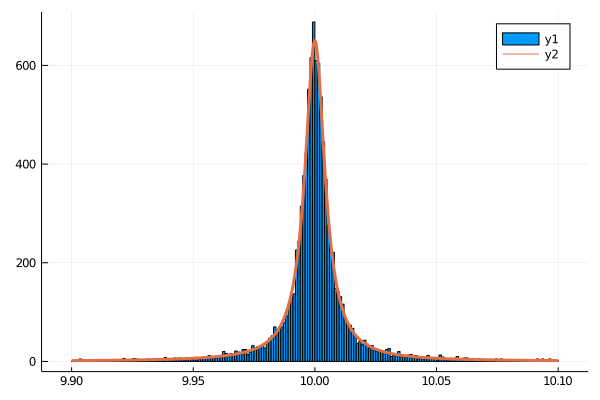

In [80]:
using SpecialFunctions

# distribution function
function lorentzian(x, μ, Γ)
    L = (1/π)*(Γ/2)/((x-μ)^2+(Γ/2)^2)
    return L
end

# another option that can be used
function voigt(x, μ, σ, Γ)
    z = ((x-μ) + 1im*Γ)/(σ*sqrt(2))
    w = erfcx(-1im*z)
    V = real(w)/(σ*sqrt(2*π))
    return V
end

# parameters
ν0 = 10.0
bw = 0.2
Γ = 0.05

# location of freqs to load
file_name = "freq_samples/50kHz/freqs.txt"

# load the sampling
freqs = readdlm(file_name)

# create a histogram
h = histogram(freqs)

# overlay with lorentzian plot
scale = 650 # have to scale up lorentzian to match
x = collect(LinRange(ν0 - bw/2, ν0 + bw/2, 10000));
plot!(x, lorentzian.(x, ν0, Γ) .* (scale/maximum(lorentzian.(x, ν0, Γ))), linewidth = 3)

# display
display(h)

# for creating frequency distributions

In [5]:
using SpecialFunctions
fspec = FormatSpec(".8f")

# distribution function
function lorentzian(x, μ, Γ)
    L = (1/π)*(Γ/2)/((x-μ)^2+(Γ/2)^2)
    return L
end

# another option that can be used
function voigt(x, μ, σ, Γ)
    z = ((x-μ) + 1im*Γ)/(σ*sqrt(2))
    w = erfcx(-1im*z)
    V = real(w)/(σ*sqrt(2*π))
    return V
end

# parameters
Γ = 0.05 # linewidth
bw = 0.5 # bandwidth
ν0 = 10.0 # central frequency
n = 100000 # number of samples

# frequency range
x = collect(LinRange(ν0 - bw/2, ν0 + bw/2, n));

# random sampling
ν = sample(x, Weights(lorentzian.(x, ν0, Γ)), n)

# outer directory
dir_name = "freq_samples"
if !isdir(dir_name)
    mkdir(dir_name)
end

# inner directory
dir_name *= "/"*string(convert(Int64, round(Γ*1e3)))*"kHz"
if !isdir(dir_name)
    mkdir(dir_name)
end
dir_name *= "/"

# save it
open(dir_name*"freqs.txt", "w") do io

    # write to text file            
    for idx = 1:length(ν)

        str = string(fmt(fspec, ν[idx]))*"\n"

        # write to the file
        write(io, str)

    end

end